# Df 0 0 2_Data Model
This tutorial shows the possibility to use data models which are more
complex than flat ntuples with RDataFrame




**Author:** Danilo Piparo  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 12:59 AM.</small></i>

In [1]:
import ROOT

Welcome to JupyROOT 6.18/03


A simple helper function to fill a test tree: this makes the example stand-alone.

In [2]:
fill_tree_code = '''
using FourVector = ROOT::Math::XYZTVector;
using FourVectorVec = std::vector<FourVector>;
using CylFourVector = ROOT::Math::RhoEtaPhiVector;

// A simple helper function to fill a test tree: this makes the example
// stand-alone.
void fill_tree(const char *filename, const char *treeName)
{
   const double M = 0.13957; // set pi+ mass
   TRandom3 R(1);

   auto genTracks = [&](){
      FourVectorVec tracks;
      const auto nPart = R.Poisson(15);
      tracks.reserve(nPart);
      for (int j = 0; j < nPart; ++j) {
         const auto px = R.Gaus(0, 10);
         const auto py = R.Gaus(0, 10);
         const auto pt = sqrt(px * px + py * py);
         const auto eta = R.Uniform(-3, 3);
         const auto phi = R.Uniform(0.0, 2 * TMath::Pi());
         CylFourVector vcyl(pt, eta, phi);
         // set energy
         auto E = sqrt(vcyl.R() * vcyl.R() + M * M);
         // fill track vector
         tracks.emplace_back(vcyl.X(), vcyl.Y(), vcyl.Z(), E);
      }
      return tracks;
   };

   ROOT::RDataFrame d(64);
   d.Define("tracks", genTracks).Snapshot<FourVectorVec>(treeName, filename, {"tracks"});
}
'''

We prepare an input tree to run on

In [3]:
fileName = "df002_dataModel_py.root"
treeName = "myTree"
ROOT.gInterpreter.Declare(fill_tree_code)
ROOT.fill_tree(fileName, treeName)

We read the tree from the file and create a RDataFrame, a class that
allows us to interact with the data contained in the tree.

In [4]:
RDF = ROOT.ROOT.RDataFrame
d = RDF(treeName, fileName)

Operating on branches which are collection of objects
Here we deal with the simplest of the cuts: we decide to accept the event
only if the number of tracks is greater than 5.

In [5]:
n_cut = 'tracks.size() > 8'
nentries = d.Filter(n_cut).Count();

print("%s passed all filters" %nentries.GetValue())

62 passed all filters


Another possibility consists in creating a new column containing the
quantity we are interested in.
In this example, we will cut on the number of tracks and plot their
transverse momentum.

In [6]:
getPt_code ='''
using namespace ROOT::VecOps;
RVec<double> getPt(const RVec<FourVector> &tracks)
{
   auto pt = [](const FourVector &v) { return v.pt(); };
   return Map(tracks, pt);
}
'''
ROOT.gInterpreter.Declare(getPt_code)

getPtWeights_code ='''
using namespace ROOT::VecOps;
RVec<double> getPtWeights(const RVec<FourVector> &tracks)
{
   auto ptWeight = [](const FourVector &v) { return 1. / v.Pt(); };
   return Map(tracks, ptWeight);
};
'''
ROOT.gInterpreter.Declare(getPtWeights_code)

augmented_d = d.Define('tracks_n', '(int)tracks.size()') \
               .Filter('tracks_n > 2') \
               .Define('tracks_pts', 'getPt( tracks )') \
               .Define("tracks_pts_weights", 'getPtWeights( tracks )' )

The histogram is initialised with a tuple containing the parameters of the
histogram

In [7]:
trN = augmented_d.Histo1D(("", "", 40, -.5, 39.5), "tracks_n")
trPts = augmented_d.Histo1D("tracks_pts")
trWPts = augmented_d.Histo1D("tracks_pts", "tracks_pts_weights")

c1 = ROOT.TCanvas()
trN.Draw()

c2 = ROOT.TCanvas()
trPts.Draw()

c3 = ROOT.TCanvas()
trWPts.Draw()

Draw all canvases 

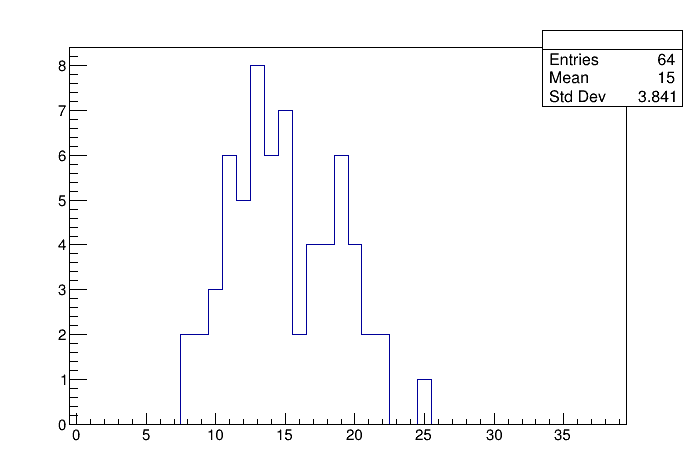

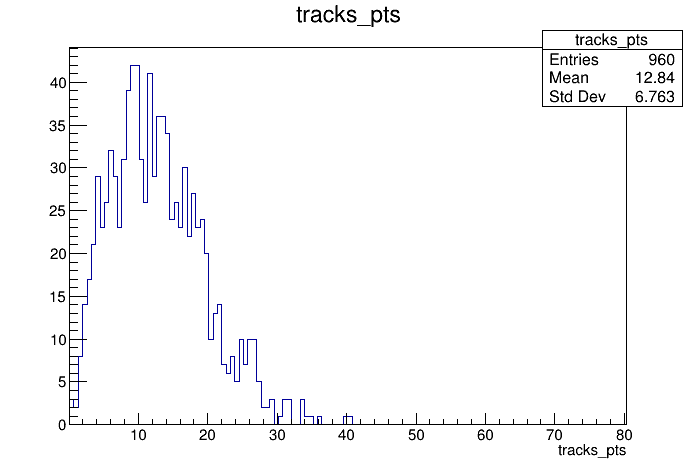

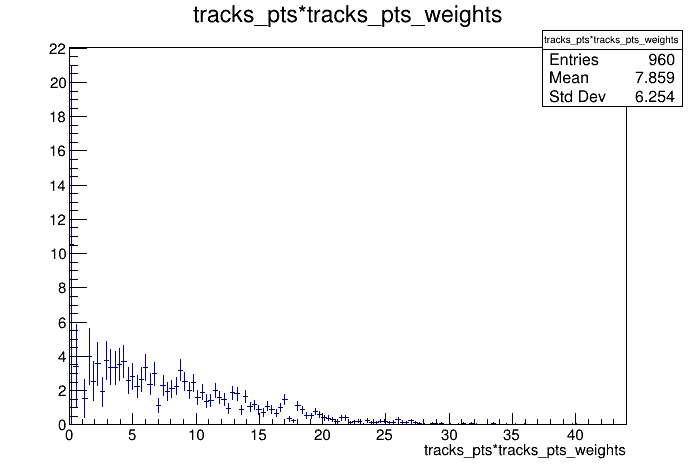

In [8]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()